<a href="https://colab.research.google.com/github/jacekwachowiak/UCA-data-science-seminars/blob/master/Lab1_CNN_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1: Convolutional Neural Networks

In this first Lab, we discover a Deep Learning framework (Pytorch), which we use to create our very first CNN (LeNet) and use it to perform handwritten character recognition with excellent accuracy.

This Lab assumes that you are familiar with the Python language. If you're not, please do Lab 0 first: https://colab.research.google.com/drive/16XlCqmmUQvwBD3D5u0lOy1rUFfDDZdYi

![alt text](https://camo.githubusercontent.com/d440ac2eee1cb3ea33340a2c5f6f15a0878e9275/687474703a2f2f692e7974696d672e636f6d2f76692f3051493378675875422d512f687164656661756c742e6a7067)

# Introduction

## What's a CNN?

![alt text](https://embarc.org/embarc_mli/doc/build/html/_images/image104.jpg)

## What's a framework and why are we using one (PyTorch)?

A programming framework is a collection of functions and utilities that is ready to use. Modern Deep Learning frameworks contain everything that is needed (layers, optimizers, losses, gradient computation...) to create and use neural networks, and make that really easy.

PyTorch, originally created by Facebook, is one of the most used frameworks, especially among researchers. The other most used framework are Tensorflow (created by Google) and Keras (an abstraction layer for multiple frameworks, including Tensorflow). PyTorch has gained a lot of popularity since its 1.0 release in 2018.

![alt text](https://miro.medium.com/max/1200/1*s_BwkYxpGv34vjOHi8tDzg.png)

## Why use Google Colab and GPUs?

Google Colab is a collaborative workspace based on Jupyter Notebook, that lets you use a Python environment on Google Cloud with GPUs, for FREE!

GPUs (Graphical Processing Units) are powerful chips that let you train and use neural networks much faster than CPUs. Having access to a GPU is very important for Deep Learning, as it can often make training more than 100x faster. It might not seem that huge at first, but state of the art neural nets can take days to train on common datasets, even with multiple powerful GPUs. On CPUs, it would take **years**.

Colab gives you access to a free Nvidia Tesla K80 (most of the time), which is a 1000€ graphics card with 24GB of VRAM.

![alt text](https://gitcdn.xyz/cdn/Tony607/blog_statics/b9259799b5bf99efdf761fed8827ff28638c8599/images/colab/pytorch-colab.png)

## /!\ IMPORTANT: Use a GPU Runtime

To use a GPU in Colab, go to Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU.

Do this step before running any of the code below, otherwise you will have to run it again.

## Importing libraries

For this lab, we only need PyTorch packages: "torch" and "torchvision".

"**torch**" contains the Deep Learning framework itself. "**torchvision**" contains datasets, pre-trained models, and image manipulation functions.

In [0]:
#Import Pytorch
import torch
import torchvision

#Little commonly used shortcut
import torch.nn as nn

#We need the display function from IPython for Jupyter Notebook/Colab
from IPython.display import display

#A package to make beautiful progress bars :) 
from tqdm import tqdm_notebook

## Downloading the data

We are working with the MNIST dataset, which containts handwritten digits.

We download the data using torchvision. We get the data in the form of a PyTorch "Dataset" object, which is a class that abstracts data loading and that can be iterated like a list.

In [0]:
mnist_dataset = torchvision.datasets.MNIST(".", train=True, download=True)

print(mnist_dataset[1])

0it [00:00, ?it/s]

100%|█████████▉| 9912320/9912422 [00:20<00:00, 1019618.70it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



0it [00:00, ?it/s]


 57%|█████▋    | 16384/28881 [00:00<00:00, 74325.80it/s]
32768it [00:00, 49471.82it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



 99%|█████████▉| 1630208/1648877 [00:08<00:00, 225972.93it/s]
1654784it [00:08, 221012.95it/s]                             

0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




  0%|          | 0/4542 [00:00<?, ?it/s]

8192it [00:00, 18185.01it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!
(<PIL.Image.Image image mode=L size=28x28 at 0x7FEC9E558E48>, 0)


We see that each element is a tuple containing a PIL Image (Python Imaging Library) and a label (0 here).
We can visualize PIL images in Colab using the **display** function.

In [0]:
display(mnist_dataset[128][0])

# Part 1: Looking at the data

In Data Science, it is very important to visualize the data we are working with, in order to understand it better and detect issues.

## Q1: Display 10 images with their label

Using a Python for loop and the **display** function, show 10 images from the dataset and their labels.

In [0]:
for i in range(20,30):
  print(mnist_dataset[i][1])
  display(mnist_dataset[i][0])

4


0


9


1


1


2


4


3


2


7


## Q2: Display 10 images from a specific class

Using a Python "for" loop and conditions (or list comprehensions), display 10 images from a specific class (4, for example).

In [0]:
mnist_4 = [x[0] for x in mnist_dataset if x[1] == 4]
for i in range(10):
  display(mnist_4[i]) 

## Q3: Count the number of elements in each class

Using a "for" loop, the "count" method and the "print" function, display the number of elements in each class of the MNIST dataset.

In [0]:
#Get only the label for each image as a list
labels = [x[1] for x in mnist_dataset]

#Use the "count" method from Python lists
for x in range(10):
  print("Number of", x, ":", labels.count(x))

Number of 0 : 5923
Number of 1 : 6742
Number of 2 : 5958
Number of 3 : 6131
Number of 4 : 5842
Number of 5 : 5421
Number of 6 : 5918
Number of 7 : 6265
Number of 8 : 5851
Number of 9 : 5949


# Part 2: Creating a Neural Network with torch.nn

For our first CNN, we are going to implement LeNet5, which was used for handwritten digits classification for the first time in 1989 (http://yann.lecun.com/exdb/lenet/).

It is common to represent Neural Network architectures using charts such as this one:

![alt text](https://miro.medium.com/fit/c/1838/551/0*H9_eGAtkQXJXtkoK) 




## Q4: Implementing the network

All networks created with torch.nn are subclasses of nn.Module.

To create our network, we need to define two methods: the init method ("\_\_init\_\_") and the **forward** propagation method.



*   In the "**init**" function, we define the **parts** (layers) of the network we are going to use and store them as attributes 
*   In the "**forward**" function, we define the **order** of the layers by applying them to an input (define-by-run)




Fill the code below so that it corresponds to the architecture represented above. Please note that there is a "ReLu" activation after every convolutional and linear (fully connected) layer, that is not pictured.

The torch.nn documentation will probably be useful https://pytorch.org/docs/stable/nn.html


In [0]:

class MyFirstNetwork(nn.Module):
  
  def __init__(self):
    super(MyFirstNetwork, self).__init__()
    
    ## MNIST images are 28x28 but LeNet5 expects 32x32
    ## -> we pad the images with zeroes
    self.padding = nn.ZeroPad2d(2)
    
    ## First convolution
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels= 6 , kernel_size = 5)
    
    ## Second convolution
    self.conv2 = nn.Conv2d(6,16,5)
    
    ## Pooling (subsampling) layer
    self.maxpool = nn.MaxPool2d(2)
    
    ## Activation layer
    self.relu = nn.ReLU()
    
    ## Fully connected layers
    self.fc1 = nn.Linear(in_features = 400, out_features = 120)
    self.fc2 = nn.Linear(120, 84)
    self.output = nn.Linear(84, 10)
    
    ## Final activation layer
    self.softmax = nn.LogSoftmax(dim=1)
    
  def forward(self, x):
    
    ## Pad the input
    x = self.padding(x)
    
    ## First convolution + activation
    x = self.conv1(x)
    x = self.relu(x)
    
    ## First pooling
    x = self.maxpool(x)
    
    ## Second Convolution + activation
    x = self.conv2(x)
    x = self.relu(x)
    
    ## Second Pooling
    x = self.maxpool(x)
    
    ## "Flatten" the output to make it 1D
    x = x.view(-1, 16*5*5)
    
    ## First full connection
    x = self.fc1(x)
    x = self.relu(x)
    
    ## Second full connection
    x = self.fc2(x)
    x = self.relu(x)
    
    ## Output layer
    x = self.output(x)
    y = self.softmax(x)
    
    return y

### Testing our implementation

To check that the network is working and possibly correct mistakes, we apply the forward method to an image from the MNIST dataset. You can do so by executing the code below.

At any point in the forward pass, you can execute Python code allowing you to debug the network. This is one of the main benefits of using PyTorch. This framework has "eager execution", and the architecture is "defined-by-run". Other frameworks, such as Tensorflow, compile the network into a fixed graph that cannot be debugged using prints.

PyTorch works on objects called **Tensors**, which are N-dimensional matrices.

Tensors can be displayed using the Python '**print**' function, their size can be accessed using **x.size()**, etc.

See the PyTorch documentation for other operations on Tensors https://pytorch.org/docs/stable/tensors.html


In [0]:
## Create an instance of our network
net = MyFirstNetwork()

## Create a conversion function to convert PIL images into Tensors
convert = torchvision.transforms.ToTensor()

## Get our input image as a tensor. We add a dimension with "unsqueeze", because
## PyTorch is used to working with batches.
x = convert(mnist_dataset[0][0]).unsqueeze(0)

## Apply the network to the input
net(x)

tensor([[-2.3610, -2.3405, -2.3804, -2.2742, -2.3617, -2.3443, -2.2552, -2.1884,
         -2.2350, -2.3037]], grad_fn=<LogSoftmaxBackward>)

The result should be a 10-dimensional vector (tensor) of probabilities. If your network does not work, edit it and try again!

NOTE: You can notice a "LogSoftmaxBackward" object. PyTorch automatically tracks which operations have been performed on Tensors, so that it can perform automatic gradient computation during training. 

#  Part 3: Training the network



## Choosing a loss function and an optimizer

As a Loss, the negative log likelihood (also called cross-entropy) is well suited here, because we have an N-class classification problem.

Stochastic Gradient Descent is the most basic optimization algorithm. You can try to use another one from torch.optim (https://pytorch.org/docs/stable/optim.html). You can also try to adjust the learning rate (lr parameter).

In [0]:
# Negative log likelihood loss
criterion = nn.NLLLoss()

# Stochastic Gradient Descent
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

## Basic training bricks

There are 4 parts to train the network on one sample of the dataset:



1.   Compute the forward pass

```
    y = net(x)
```


2.   Compute the loss


```
    loss = criterion(y.unsqueeze(0), label)
```


3.   Reset the gradients


```
    optimizer.zero_grad()
```


4.   Compute the backward pass



```
     loss.backward()

```



5.   Apply one optimization step



```
     optimizer.step()

```





## Q5: Creating a basic training loop

Neural Networks are trained using training loops. We go over the dataset multiple times (each time is called an "epoch"), using "batches" of data.

First, we are going to create the most basic training loop possible, going over the dataset manually using a batch size of 1 (the network sees the images one by one). Every time an image goes through the network, we compute the loss and the gradients and update the network weights.

Fill the code below using the basic training bricks above to create the training loop.

In [0]:
## MODIFY THIS LINE IF THE TRAINING TAKES TOO LONG
SAMPLES_TO_USE = 1000

## NUMBER OF EPOCHS TO TRAIN
N_EPOCHS = 10

## Put the network in training mode
net.train()

for e in range(N_EPOCHS):
  print("EPOCH:",e)
  
  running_loss = 0
  running_accuracy = 0
  
  for i in range(SAMPLES_TO_USE):
    
    # Get a sample from the dataset
    sample = mnist_dataset[i]
    x = convert(sample[0]).unsqueeze(0)
    label = torch.tensor([sample[1]])

    # Compute the network output
    y = net(x)
    
    # Compute the loss
    loss = criterion(y, label)
    
    # Reset the gradients
    optimizer.zero_grad()
    
    # Compute the gradients
    loss.backward()
    
    # Apply one step of the descent algorithm to update the weights
    optimizer.step()
    
    ## Compute some statistics
    running_loss += loss.data
    running_accuracy += 1 if y.max(1)[1] == label else 0
    
  print("Training accuracy:", running_accuracy/SAMPLES_TO_USE)
  print("Training loss:", running_loss/SAMPLES_TO_USE)
      

EPOCH: 0
Training accuracy: 0.12
Training loss: tensor(2.2977)
EPOCH: 1
Training accuracy: 0.5
Training loss: tensor(1.4999)
EPOCH: 2
Training accuracy: 0.834
Training loss: tensor(0.5633)
EPOCH: 3
Training accuracy: 0.903
Training loss: tensor(0.3007)
EPOCH: 4
Training accuracy: 0.947
Training loss: tensor(0.2036)
EPOCH: 5
Training accuracy: 0.947
Training loss: tensor(0.1670)
EPOCH: 6
Training accuracy: 0.969
Training loss: tensor(0.1018)
EPOCH: 7
Training accuracy: 0.977
Training loss: tensor(0.0701)
EPOCH: 8
Training accuracy: 0.977
Training loss: tensor(0.0571)
EPOCH: 9
Training accuracy: 0.983
Training loss: tensor(0.0662)


## Evaluating on a test set

While performance on the training set might be good (you can reach 100% accuracy in this example), what really matters is performance on the test set. The test set is composed of images the network has never seen before.

Run the following code to evaluate your network. Please make sure that you reach at least approximately 90% test accuracy before moving on to the next question!

In [0]:
#Get the MNIST test set
mnist_test_dataset = torchvision.datasets.MNIST(".", train=False, transform=convert, download=True)

print("Number of test images:", len(mnist_test_dataset))

#Put the network in eval mode
net.eval()

acc = 0
#Disable gradient computation for this (we do not need them, this will speed up testing)
with torch.no_grad():
  for img, label in mnist_test_dataset:

    y = net(img.unsqueeze(0))

    if y.max(1)[1] == label:
      acc +=1

  print("Test Accuracy:", acc/len(mnist_test_dataset))


Number of test images: 10000
Test Accuracy: 0.9283


## Q6: Displaying a few random results from the test set

Let's look at some results, to visualize in which cases our network makes mistakes.

Using Python's **random** package and your trained neural network, display 10 results from the test set.

HINT: to get the network output for a sample as a number, you can use: 

```
    net(convert(sample[0]).unsqueeze(0)).max(1)[1]
```



In [0]:
import random

mnist_test_dataset_PIL = torchvision.datasets.MNIST(".", train=False, download=True)

for i in range(10):
  n = random.randint(0, len(mnist_test_dataset)-1)
  
  sample = mnist_test_dataset_PIL[n]
  
  display(sample[0])
  print("Expected output:", sample[1])
  print("Network output:", net(convert(sample[0]).unsqueeze(0)).max(1)[1])

Expected output: 0
Network output: tensor([0])


Expected output: 8
Network output: tensor([7])


Expected output: 9
Network output: tensor([9])


Expected output: 2
Network output: tensor([2])


Expected output: 7
Network output: tensor([7])


Expected output: 8
Network output: tensor([3])


Expected output: 8
Network output: tensor([8])


Expected output: 7
Network output: tensor([7])


Expected output: 2
Network output: tensor([2])


Expected output: 3
Network output: tensor([3])


# Part 4: Creating a better training loop

Our basic training method works, but as you might have noticed it is pretty slow.
In this section, we improve it to create a "good" PyTorch training loop, by using batches, data loaders, validation data, and GPUs.

## Splitting between validation and training data

It is common to split the training dataset into a training set and a validation set. 

The network is trained on the training set, and its performance is validated at each epoch using the validation set.

This is used to prevent overfitting. If the training accuracy/loss improves but the validation accuracy/loss stagnate or worsen we are **overfitting** the training set.

The final evaluation is still done on the test set.

![Texte alternatif…](https://miro.medium.com/max/1552/1*Nv2NNALuokZEcV6hYEHdGA.png)

This is very easy in PyTorch. Let's split our MNIST **Dataset** into two random **Subsets** (it's a subclass of **Dataset**).

In [0]:
## Load Dataset
mnist_dataset = torchvision.datasets.MNIST(".", train=True, transform=convert, download=True)

## Percentage of validation data
validation_split = 0.1

N_val_samples = round(validation_split * len(mnist_dataset))

## Split into two Subset
train_set, val_set = torch.utils.data.random_split(mnist_dataset, [len(mnist_dataset) - N_val_samples, N_val_samples])

# train and val are Subset objects
print(train_set)
print(val_set)

# Their sizes should be correct
len(train_set) + len(val_set) == len(mnist_dataset)

True

## DataLoaders in PyTorch

In PyTorch, **DataLoaders** are tools that load **batches** of data from a **Dataset** (or any of its subclasses).

Training in batches of multiple samples (8, 32, 512...) can be a lot faster thanks to parallelism. Also, it helps with gradient descent by averaging the gradient over the whole batch.

Documentation on DataLoaders is here: https://pytorch.org/docs/stable/data.html

In [0]:
## This line creates a basic DataLoader from our mnist training set

## You can change options such as batch size, shuffling, number of workers...

BATCH_SIZE = 64

mnist_train_dl = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

## Q7: Use the DataLoaders

Using the DataLoader we just created, print the number of batches it contains (you should see len(train_set)/batch_size), and print a batch from the dataset.

HINT: you can get a Python iterator from a DataLoader using the **iter** function, because a DataLoader is an **iterable** object. https://wiki.python.org/moin/Iterator

You should see a number of samples and labels equal to your batch size.

In [0]:
## Print the length of the dataloader
print(len(mnist_train_dl))

## Print a batch
print(next(iter(mnist_train_dl)))


844
[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..

## Q8: Create a DataLoader for the validation set

In the same way, create a DataLoader for the validation set.

In [0]:
mnist_val_dl = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

## Using a GPU

Using a GPU in PyTorch is very easy and will make our training A LOT faster.

To perform calculations on a batch on the GPU, our batch has to be moved to the GPU.

To move a Tensor to the GPU memory, use the **cuda()** method.

If you do not have a GPU, you will get a cuda runtime error. To add a GPU to Colab, go to Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU.

In [0]:
batch = torch.Tensor(next(iter(mnist_train_dl))[0])

batch = batch.cuda()

You can see "device='cuda:0'", which means our Tensor has been moved to the first GPU in the system!

Now, we also need to move our neural network to the GPU, because the computations between the network weights and the training data will happen on the GPU.

For this, we also use the **cuda()** method.

In [0]:
## Create an instance of our network
net = MyFirstNetwork()

## Move it to the GPU
net = net.cuda()

Let's test this by computing an output on the GPU.

In [0]:
output = net(batch)

print(output)

tensor([[-2.1777, -2.2939, -2.3504, -2.3125, -2.2808, -2.4045, -2.1965, -2.3070,
         -2.3791, -2.3477],
        [-2.1802, -2.2892, -2.3463, -2.3126, -2.2825, -2.4035, -2.1995, -2.3005,
         -2.3814, -2.3540],
        [-2.1848, -2.2928, -2.3454, -2.3048, -2.2823, -2.3962, -2.2043, -2.3066,
         -2.3791, -2.3511],
        [-2.1749, -2.2891, -2.3462, -2.3128, -2.2830, -2.4061, -2.2023, -2.3067,
         -2.3764, -2.3525],
        [-2.1755, -2.2946, -2.3459, -2.3147, -2.2831, -2.4012, -2.1995, -2.3048,
         -2.3786, -2.3518],
        [-2.1751, -2.2909, -2.3476, -2.3135, -2.2823, -2.4021, -2.2031, -2.3024,
         -2.3801, -2.3525],
        [-2.1805, -2.2934, -2.3380, -2.3151, -2.2849, -2.3995, -2.2046, -2.3069,
         -2.3729, -2.3518],
        [-2.1809, -2.2970, -2.3427, -2.3097, -2.2899, -2.4007, -2.1905, -2.3059,
         -2.3823, -2.3502],
        [-2.1835, -2.2897, -2.3540, -2.3111, -2.2829, -2.4040, -2.1954, -2.3078,
         -2.3708, -2.3500],
        [-2.1774, -

## Q9: Our new training/validation loop

Now, we have all the necessary bricks to build our new improved training/validation loop!

We have already written the training loop for you. Complete the validation loop!

You should see that your network trains very fast on the whole training set now. One epoch should take about 10 seconds, depending on your batch size, compared to about 3 minutes on the CPU.

In [0]:
##RE-RUN THIS CODE TO GET A "NEW" NETWORK

LEARNING_RATE = 0.003
MOMENTUM = 0.9

## Create an instance of our network
net = MyFirstNetwork()

## Move it to the GPU
net = net.cuda()

# Negative log likelihood loss
criterion = nn.NLLLoss()

# Stochastic Gradient Descent
optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [0]:
## NUMBER OF EPOCHS TO TRAIN
N_EPOCHS = 5

epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []

for e in range(N_EPOCHS):
  
  print("EPOCH:",e)
  
  ### TRAINING LOOP
  running_loss = 0
  running_accuracy = 0
  
  ## Put the network in training mode
  net.train()
  
  for i, batch in enumerate(train_dl):
    
    # Get a batch from the dataloader
    x = batch[0]
    labels = batch[1]
    
    # move the batch to GPU
    x = x.cuda()
    labels = labels.cuda()

    # Compute the network output
    y = net(x)
    
    # Compute the loss
    loss = criterion(y, labels)
    
    # Reset the gradients
    optimizer.zero_grad()
    
    # Compute the gradients
    loss.backward()
    
    # Apply one step of the descent algorithm to update the weights
    optimizer.step()
    
    ## Compute some statistics
    with torch.no_grad():
      running_loss += loss.item()
      running_accuracy += (y.max(1)[1] == labels).sum().item()
    
  print("Training accuracy:", running_accuracy/float(len(train_set)),
        "Training loss:", running_loss/float(len(train_set)))
  
  epoch_loss.append(running_loss/len(train_set))
  epoch_acc.append(running_accuracy/len(train_set))
  
  ### VALIDATION LOOP
  ## Put the network in validation mode
  net.eval()
  
  running_val_loss = 0
  running_val_accuracy = 0
  
  for i, batch in enumerate(mnist_val_dl):
    
    with torch.no_grad():
      # Get a batch from the dataloader
      x = batch[0]
      labels = batch[1]

      # move the batch to GPU
      x = x.cuda()
      labels = labels.cuda()

      # Compute the network output
      y = net(x)
      
      # Compute the loss
      loss = criterion(y, labels)
      
      running_val_loss += loss.item()
      running_val_accuracy += (y.max(1)[1] == labels).sum().item()
    
  print("Validation accuracy:", running_val_accuracy/float(len(val_set)),
        "Validation loss:", running_val_loss/float(len(val_set)))
  
  epoch_val_loss.append(running_val_loss/len(val_set))
  epoch_val_acc.append(running_val_accuracy/len(val_set))
      

EPOCH: 0
Training accuracy: 0.5314814814814814 Training loss: 0.021476175299535195
Validation accuracy: 0.9086666666666666 Validation loss: 0.004505582701414824
EPOCH: 1
Training accuracy: 0.940037037037037 Training loss: 0.003011596926936397
Validation accuracy: 0.9546666666666667 Validation loss: 0.002399400315557917
EPOCH: 2
Training accuracy: 0.9658888888888889 Training loss: 0.0017450899534203388
Validation accuracy: 0.9731666666666666 Validation loss: 0.0014168341184655825
EPOCH: 3
Training accuracy: 0.9728703703703704 Training loss: 0.0013080303701227187
Validation accuracy: 0.979 Validation loss: 0.0010841335679093998
EPOCH: 4
Training accuracy: 0.9789444444444444 Training loss: 0.0010802410772001302
Validation accuracy: 0.9785 Validation loss: 0.0010268216083447138


## Q10: Making a graph with training/validation accuracy and loss

You can visualize your losses and accuracies over time using matplotlib.

Modify the training/val loop above to store the values (in a list), and display them in a graph.

Can you spot the moment where we start to overfit the training set? 

Try adjusting the number of epochs, the batch size, the learning rate or changing the optimizer (add some momentum or try Adam) to get a better result on the validation set.

Optimizers documentation: https://pytorch.org/docs/stable/optim.html#algorithms

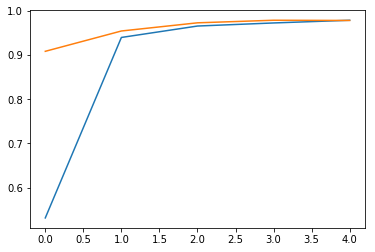

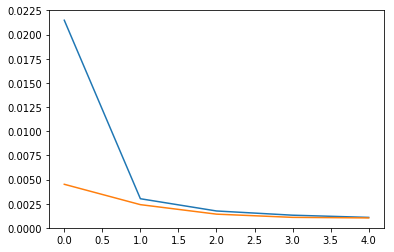

In [0]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(N_EPOCHS)
plt.figure()
plt.plot(x, epoch_acc, x, epoch_val_acc)

plt.figure()
plt.plot(x, epoch_loss, x, epoch_val_loss)


## Q11: Evaluate our network on the test set (on GPU)

In the same way you wrote the validation loop, create a DataLoader on the mnist test dataset, and write a test loop!

You should be able to get 90% accuracy on the test set :)


In [0]:
#Get the MNIST test set
mnist_test_dataset = torchvision.datasets.MNIST(".", train=False, transform=convert, download=True)

#Create a DataLoader

mnist_test_dl = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=64)

net.eval()

test_loss = 0
test_accuracy = 0

for i, batch in enumerate(mnist_test_dl):

  with torch.no_grad():
    # Get a batch from the dataloader
    x = batch[0]
    labels = batch[1]

    # move the batch to GPU
    x = x.cuda()
    labels = labels.cuda()

    # Compute the network output
    y = net(x)

    # Compute the loss
    loss = criterion(y, labels)

    test_loss += loss.item()
    test_accuracy += (y.max(1)[1] == labels).sum().item()

print("Test accuracy:", test_accuracy/float(len(mnist_test_dataset)),
      "Test loss:", test_loss/float(len(mnist_test_dataset)))

Test accuracy: 0.9806 Test loss: 0.0009056597933173179


# (OPTIONAL) Part 5: Cats vs Dogs with a torchvision network

To test our skills on a new dataset, we will work on the famous Dogs vs Cats Kaggle dataset.

![alt text](http://adilmoujahid.com/images/cats-dogs.jpg)

Kaggle is a website that hosts machine learning/data science competitions. Check it out! https://www.kaggle.com/

![alt text](https://miro.medium.com/max/668/1*GZrTyTz0OKMbxnO5Trhcew.png)

## Downloading the data

First, go to the Kaggle website and create an account.

Then go to your account, click on Create New API Token - It will download kaggle.json file on your machine.

Upload the kaggle.json file using this code:




In [0]:
! pip install -q kaggle

from google.colab import files

files.upload()

Download the dogs vs cats dataset using this code:

In [0]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c dogs-vs-cats

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 89.1MB/s]
 95% 258M/271M [00:01<00:00, 222MB/s]
100% 271M/271M [00:01<00:00, 210MB/s]
 99% 538M/543M [00:03<00:00, 192MB/s]
100% 543M/543M [00:03<00:00, 173MB/s]


Extract the archives:

In [0]:
! rm -rf test1 train

! unzip -q train.zip

! unzip -q test1.zip

Put the data in separate directories:

In [0]:
! mkdir train/cats
! mkdir train/dogs
! mv train/cat.* train/cats
! mv train/dog.* train/dogs

## Q12: Load the data

Using ImageFolder from torchvision (https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder), load the dataset.

In [0]:
ds = torchvision.datasets.ImageFolder("train")

## Q13: Display a few images

As before, display a few images with the **display** function. You can see that these images have varying sizes.

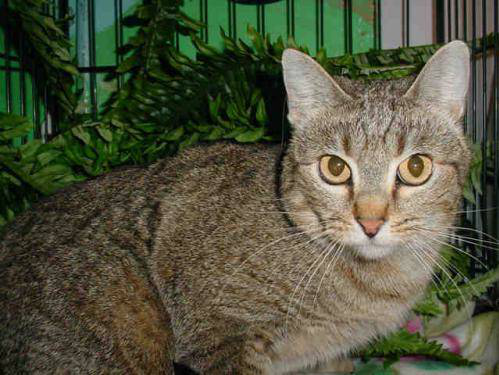

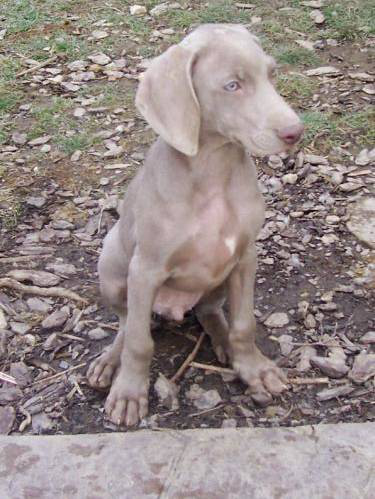

(<PIL.Image.Image image mode=RGB size=431x359 at 0x7FEC93E57128>, 0)
(<PIL.Image.Image image mode=RGB size=124x125 at 0x7FEC93E57D68>, 1)


In [0]:
display(ds[1337][0])
display(ds[13969][0])
print(ds[5])
print(ds[18413])

## Using a torchvision model

torchvision has a repository of popular models ready to use for diverse computer vision tasks (classification, segmentation,...)

https://pytorch.org/docs/stable/torchvision/models.html#classification



In [0]:
## You can change the model if you want
net = torchvision.models.resnet18()

## torchvision models are meant to be used on imagenet (1000 classes)
## since we only have two classes, we need to modify the last layer

net.fc = nn.Linear(512,2)

## Q14: Resize the images on the fly using torchvision transforms 

We can see from the documentation that torchvision models expect at least 224x244 images.

Using torchvision.transforms, create a new ImageFolder dataset with on-the-fly resizing of images.

Split this Dataset into training and validation sets.

Create a DataLoader for each set as well, just like before.

In [0]:
convert = torchvision.transforms.Compose([torchvision.transforms.Resize((299,299)), torchvision.transforms.ToTensor()])

ds = torchvision.datasets.ImageFolder("train", transform = convert)

dl = torch.utils.data.DataLoader(ds, batch_size = 8)

## Percentage of validation data
validation_split = 0.1

N_val_samples = round(validation_split * len(ds))

## Split into two Subset
cd_train_set, cd_val_set = torch.utils.data.random_split(ds, [len(ds) - N_val_samples, N_val_samples])

cd_train_dl = torch.utils.data.DataLoader(cd_train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

cd_val_dl = torch.utils.data.DataLoader(cd_val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

## Q15: Training the model

Write the training loop. You should be able to pretty much copy-paste the one from Q9.

In [0]:
LEARNING_RATE = 0.001

## Move model to the GPU
net = net.cuda()

# Negative log likelihood loss
criterion = nn.CrossEntropyLoss()

# Stochastic Gradient Descent
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [0]:
## NUMBER OF EPOCHS TO TRAIN
N_EPOCHS = 5

epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []

for e in range(N_EPOCHS):
  
  print("EPOCH:",e)
  
  ### TRAINING LOOP
  running_loss = 0
  running_accuracy = 0
  
  ## Put the network in training mode
  net.train()
  
  for i, batch in enumerate(cd_train_dl):
    
    # Get a batch from the dataloader
    x = batch[0]
    labels = batch[1]
    
    # move the batch to GPU
    x = x.cuda()
    labels = labels.cuda()

    # Compute the network output
    y = net(x)
    
    # Compute the loss
    loss = criterion(y, labels)
    
    # Reset the gradients
    optimizer.zero_grad()
    
    # Compute the gradients
    loss.backward()
    
    # Apply one step of the descent algorithm to update the weights
    optimizer.step()
    
    ## Compute some statistics
    with torch.no_grad():
      running_loss += loss.item()
      running_accuracy += (y.max(1)[1] == labels).sum().item()
    
  print("Training accuracy:", running_accuracy/float(len(cd_train_set)),
        "Training loss:", running_loss/float(len(cd_train_set)))
  
  epoch_loss.append(running_loss/len(cd_train_set))
  epoch_acc.append(running_accuracy/len(cd_train_set))
  
  ### VALIDATION LOOP
  ## Put the network in validation mode
  net.eval()
  
  running_val_loss = 0
  running_val_accuracy = 0
  
  for i, batch in enumerate(cd_val_dl):
    
    with torch.no_grad():
      # Get a batch from the dataloader
      x = batch[0]
      labels = batch[1]

      # move the batch to GPU
      x = x.cuda()
      labels = labels.cuda()

      # Compute the network output
      y = net(x)
      
      # Compute the loss
      loss = criterion(y, labels)
      
      running_val_loss += loss.item()
      running_val_accuracy += (y.max(1)[1] == labels).sum().item()
    
  print("Validation accuracy:", running_val_accuracy/float(len(cd_val_set)),
        "Validation loss:", running_val_loss/float(len(cd_val_set)))
  
  epoch_val_loss.append(running_val_loss/len(cd_val_set))
  epoch_val_acc.append(running_val_accuracy/len(cd_val_set))
      

EPOCH: 0
Training accuracy: 0.6371555555555556 Training loss: 0.009998226686318716
Validation accuracy: 0.6692 Validation loss: 0.010200523006916045
EPOCH: 1
Training accuracy: 0.7232 Training loss: 0.008507697723971473
Validation accuracy: 0.6612 Validation loss: 0.011654306221008302
EPOCH: 2
Training accuracy: 0.7932 Training loss: 0.007033138783772787
Validation accuracy: 0.7308 Validation loss: 0.008687843799591064
EPOCH: 3
Training accuracy: 0.8358666666666666 Training loss: 0.005754435839255651
Validation accuracy: 0.764 Validation loss: 0.008430767571926116
EPOCH: 4
Training accuracy: 0.8679555555555556 Training loss: 0.004694655950201882
Validation accuracy: 0.8076 Validation loss: 0.006586453431844711


## Q16: Test the network

Compute some predictions on the test set.

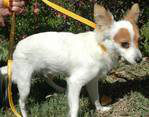

Network prediction: cat


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


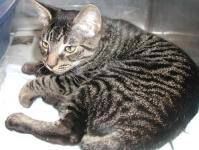

Network prediction: cat


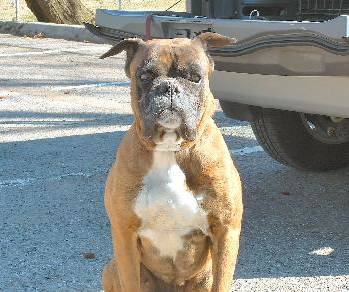

Network prediction: dog


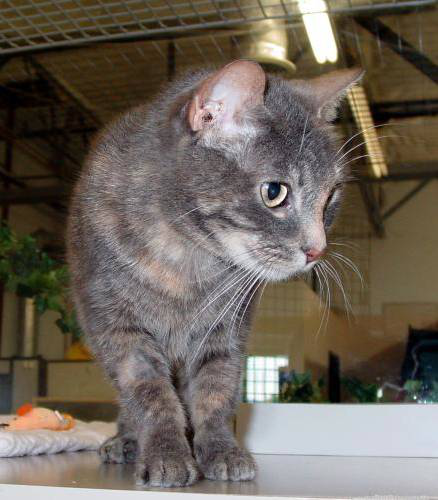

Network prediction: cat


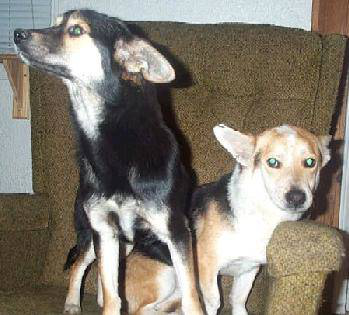

Network prediction: dog


In [0]:
import glob
from PIL import Image

names = glob.glob("test1/*")

for i in range(5):
  n = random.randint(0, len(names))
  
  img = Image.open(names[n])
  display(img)
  
  y = nn.functional.softmax(net(convert(img).unsqueeze(0).cuda()))
  if y[0][0] > y[0][1]:
    print("Network prediction: cat")
  else:
    print("Network prediction: dog")

## Q17: Going further

Try different networks from torchvision, and different parameters. The winner of the competition got more than 98% accuracy. How much can you get?

Data augmentation (modifying your input data to make "more" of it) is a huge thing in deep learning. Try some techniques such as random cropping and rotation using torchvision transforms in your Dataset objects!

PyTorch has a lot of tutorials to get you started: https://pytorch.org/tutorials/index.html

Have fun!
